# Homework 1: CuPy-based Bifurcation map
by Rustam Guseyn-zade ([link canvas](https://skoltech.instructure.com/courses/3546/users/9673))

## Table of contents
* [Bifurcation on CuPy arrays](#Bifurcation-on-CuPy-arrays)
* [CuPy bifurcation map profiled](#CuPy-bifurcation-map-profiled)
* [GPU vs CPU vs MPI](#GPU-vs-CPU-vs-MPI)

In [1]:
!pip3 install mpi4py

In [2]:
# import needed libraries
import argparse
import cupy as cp
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mpi4py
import time

## Bifurcation on CuPy arrays

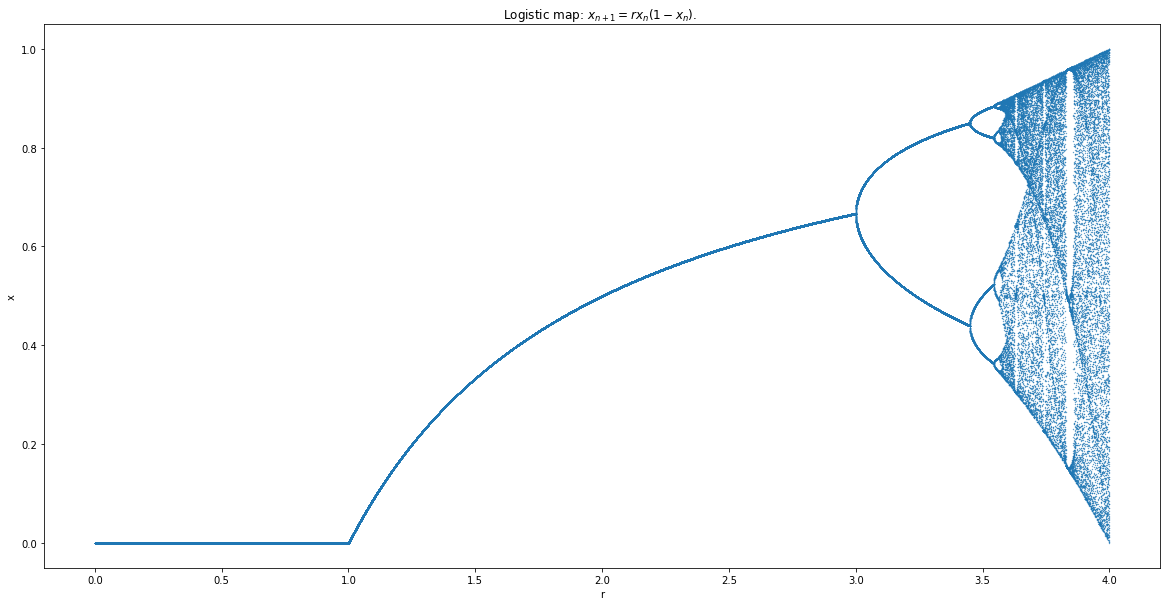

In [3]:
def cupy_bifurcation(xs_amount):
  x = cp.random.rand(xs_amount)
  r = cp.linspace(0, 4.0, num=xs_amount)
  
  for i in range(1, 10000):
    inverted_x = 1 - x
    updated_x = cp.multiply(x,r)
    updated_x = cp.multiply(updated_x, inverted_x)
    x = updated_x
  print(f"{i}/10000", end='\r')
  
  return x, r

x, r = cupy_bifurcation(250000)
plt.figure(figsize=(20, 10))
plt.title(r'Logistic map: $x_{n+1} = r x_{n} (1-x_{n}).$ ')
plt.ylabel('x')
plt.xlabel('r')
    
plt.scatter(cp.asnumpy(r), cp.asnumpy(x), s=0.1)
plt.show()

## CuPy bifurcation map profiled

In [4]:
cProfile.run('cupy_bifurcation(250000)')

         30072 function calls in 2.725 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     9999    0.043    0.000    0.152    0.000 <__array_function__ internals>:2(min_scalar_type)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(result_type)
        1    2.572    2.572    2.725    2.725 <ipython-input-3-a659f0ae9aae>:1(cupy_bifurcation)
        1    0.000    0.000    2.725    2.725 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 __init__.py:374(result_type)
        1    0.000    0.000    0.000    0.000 __init__.py:380(<listcomp>)
        2    0.000    0.000    0.000    0.000 __init__.py:503(isscalar)
        1    0.000    0.000    0.000    0.000 _generator.py:1276(get_random_state)
        1    0.000    0.000    0.000    0.000 _generator.py:1312(_check_and_get_dtype)
        1    0.000    0.000    0.000    0.000 _generator.py:598(_random_sample_raw)
        1    0.000    0

## GPU vs CPU vs MPI

In [5]:
def bifurcation(xs_amount):
  x = np.random.rand(xs_amount)
  r = np.linspace(0, 4.0, num=xs_amount)

  for i in range(1, 10000):
    inverted_x = 1 - x
    updated_x = np.multiply(x,r)
    updated_x = np.multiply(updated_x, inverted_x)
    x = updated_x
    print(f"{i}/10000", end='\r')
  return x, r

In [6]:
%%writefile bifurcation.py
# Create file bifurcation.py
import matplotlib.pyplot as plt
from mpi4py import MPI
import argparse
import numpy as np

def parseOptions(comm):
    parser = argparse.ArgumentParser(
        description='Print some messages.')

    parser.add_argument('xs_amount', help='How many dots', type=int)

    args = None
    try:
        if comm.Get_rank() == 0:
            args = parser.parse_args()
    finally:
        args = comm.bcast(args, root=0)

    if args is None:
        exit(0)
    return args


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

args = parseOptions(comm)

if rank == 0:
  print(args.xs_amount)

xs_amount = args.xs_amount
r = np.linspace(0, 4.0, num=xs_amount)

chunk_size = xs_amount//size + 1
chunk_head = chunk_size * rank
chunk_tail = chunk_size * (rank + 1)
if chunk_tail > xs_amount:
    chunk_tail = xs_amount
    
x = np.random.rand((chunk_tail-chunk_head))
for i in range(1, 10000):
    inverted_x = 1 - x
    updated_x = np.multiply(x,r[chunk_head:chunk_tail])
    updated_x = np.multiply(updated_x, inverted_x)
    x = updated_x
print(f"process {rank}: from {chunk_head} to {chunk_tail}")
  
all_x_patched = comm.gather((chunk_head, x),root=0)

if rank == 0:
    all_x = []
    for x_patch in sorted(all_x_patched):
        all_x = np.append(all_x, x_patch[1])
    print("done")

Overwriting bifurcation.py


In [7]:
!mpirun --allow-run-as-root -np 3 python3 bifurcation.py 100000

100000
process 2: from 66668 to 100000
process 1: from 33334 to 66668
process 0: from 0 to 33334
done


In [8]:
number_iterations = 10
xs_amounts = np.linspace(1000, 500000, 10).astype(int)

def measure_n_processes_time(processes_number, dots, attempts=1):
    number_processes_time = []
    if attempts == 1:
      start = time.time()
      !mpirun --allow-run-as-root -np {processes_number} python3 bifurcation.py {dots} >/dev/null 2>&1
      end = time.time()
      number_processes_time.append(end - start)
      iter_number = np.where(xs_amounts == dots)[0][0]
      print(f'mpi measure for {processes_number} processes [{iter_number+1}/{number_iterations}]')
    else:
      for i in range(attempts):
        start = time.time()
        !mpirun --allow-run-as-root -np {processes_number} python3 bifurcation.py {dots} >/dev/null 2>&1
        end = time.time()
        number_processes_time.append(end - start)
        iter_number = np.where(xs_amounts == dots)[0][0]
        print(f'mpi measure attempt {i+1} from {attempts} for {processes_number} processes [{iter_number+1}/{number_iterations}]')
    return sum(number_processes_time) / attempts

measuring for basic
basic measure [1/10]
basic measure [2/10]
basic measure [3/10]
basic measure [4/10]
basic measure [5/10]
basic measure [6/10]
basic measure [7/10]
basic measure [8/10]
basic measure [9/10]
basic measure [10/10]
measuring for cupy
cupy measure [1/10]
cupy measure [2/10]
cupy measure [3/10]
cupy measure [4/10]
cupy measure [5/10]
cupy measure [6/10]
cupy measure [7/10]
cupy measure [8/10]
cupy measure [9/10]
cupy measure [10/10]
measuring for mpi
mpi measure for 1 processes [1/10]
mpi measure for 1 processes [2/10]
mpi measure for 1 processes [3/10]
mpi measure for 1 processes [4/10]
mpi measure for 1 processes [5/10]
mpi measure for 1 processes [6/10]
mpi measure for 1 processes [7/10]
mpi measure for 1 processes [8/10]
mpi measure for 1 processes [9/10]
mpi measure for 1 processes [10/10]
mpi measure for 2 processes [1/10]
mpi measure for 2 processes [2/10]
mpi measure for 2 processes [3/10]
mpi measure for 2 processes [4/10]
mpi measure for 2 processes [5/10]
mpi m

Text(0.5, 1.0, 'Bifurcation map using different methods')

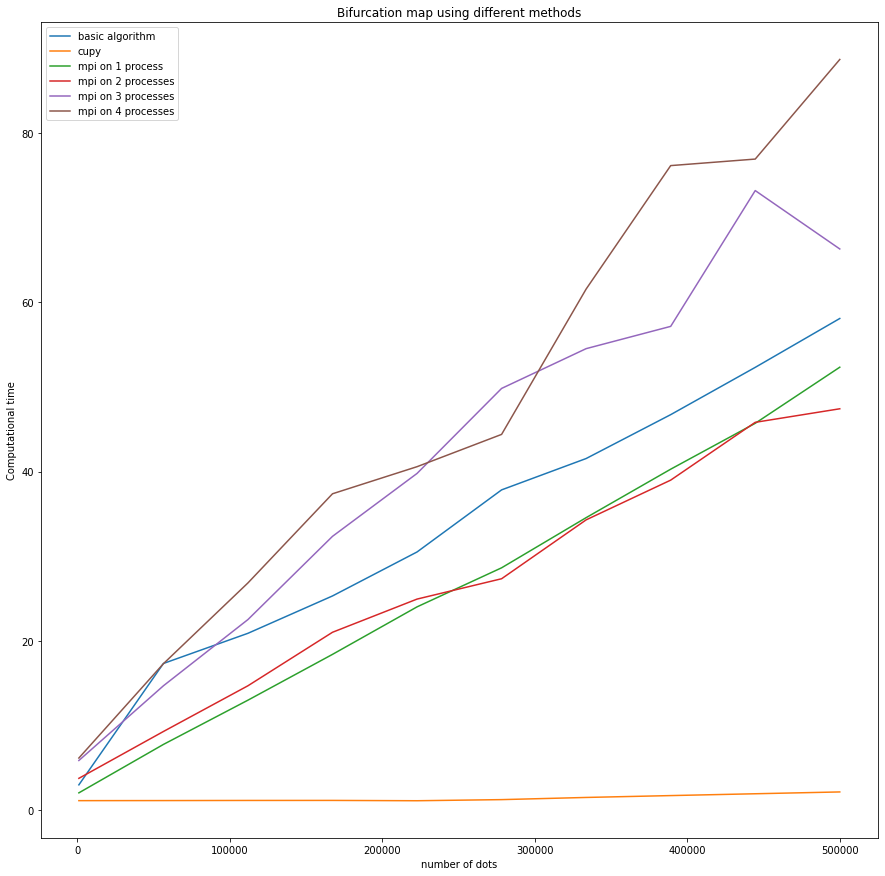

In [10]:
basic_times = []
print("measuring for basic")
for i in range(number_iterations):
  xs_amount = xs_amounts[i]
  start = time.time()
  _ = bifurcation(xs_amount)
  end = time.time()
  print(f'basic measure [{i+1}/{number_iterations}]')
  basic_times.append(end - start)

cupy_times = []
print("measuring for cupy")
for i in range(number_iterations):
  xs_amount = xs_amounts[i]
  start = time.time()
  _ = cupy_bifurcation(xs_amount)
  end = time.time()
  print(f'cupy measure [{i+1}/{number_iterations}]')
  cupy_times.append(end - start)

print("measuring for mpi")
mpi1_times = [measure_n_processes_time(1, xs_amount) for xs_amount in xs_amounts]
mpi2_times = [measure_n_processes_time(2, xs_amount) for xs_amount in xs_amounts]
mpi3_times = [measure_n_processes_time(3, xs_amount) for xs_amount in xs_amounts]
mpi4_times = [measure_n_processes_time(4, xs_amount) for xs_amount in xs_amounts]
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(xs_amounts, basic_times, label="basic algorithm")
ax.plot(xs_amounts, cupy_times, label="cupy")
ax.plot(xs_amounts, mpi1_times, label="mpi on 1 process")
ax.plot(xs_amounts, mpi2_times, label="mpi on 2 processes")
ax.plot(xs_amounts, mpi3_times, label="mpi on 3 processes")
ax.plot(xs_amounts, mpi4_times, label="mpi on 4 processes")
plt.legend()
plt.ylabel('Computational time')
plt.xlabel('number of dots')
plt.title('Bifurcation map using different methods')